# Определение тональности постов Telegram-канала

__Цель__ - Анализ тональности тех или иных тем Telegram-канала.

__Задачи__ :
- Реализация алгоритма кластеризации полученного текста (разделение текстов на темы)
- Реализация алгоритма классификации тональности постов, принадлежащих той или иной теме

## Кластеризация текстов

___Кластерный анализ (Data clustering)___$^1$ — задача разбиения заданной выборки $X$ объектов на непересекающиеся или частично пересекающиеся подмножества $С_i \neq \emptyset $, называемые кластерами. В случае __жесткой__ кластеризации имеем: $$\bigcup_{i} C_i = X$$
При этом каждый $i^{ый}$ кластер должен состоять из схожих объектов, т.е. $(c^i_j, c^i_k - $ похожи$)(\forall j \neq k, c^i_j \in C_i, c^i_k \in C_i)$, а объекты разных кластеров $i, m$ должны существенно отличаться, т.е. $(c^i_j, c^m_k - $ не похожи$)(\forall j,k, i \neq m, c^i_j \in C_i, c^m_k \in C_m)$. Схожесть объектов определяется некоторой функцией расстояния  $d:X \times X \rightarrow \mathbb{R}^+ $

В нашем случае задача кластеризации является __вспомогательной__, так как она является частью другой задачи, а именно задачи определения тональности текста.

$^1 - \ $[Старница про класстеризацию с сайта machinelearning](http://www.machinelearning.ru/wiki/index.php?title=Кластеризация)

### Подключение необходимых библиотек и предварительные настройки

In [1220]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, silhouette_score
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from ufal.udpipe import Model, Pipeline
from tqdm import tqdm
from wordcloud import WordCloud
import wget
import itertools
from pprint import pprint
import os
import re
import sys

import pymorphy2
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import regexp_tokenize 
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import numpy as np
import pandas as pd
import gensim

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vlad_voropaev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vlad_voropaev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vlad_voropaev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [391]:
# Задаем seed для ГСЧ для воспроизводимости результатов
RANDOM_SEED = 7

Используем функцию [`fetch_20newsgroups`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups) для скачивания набора данных, с помощью которого мы подборем оптимальный алгоритм кластеризации. 

Набор данных [__20newsgroups__](http://qwone.com/~jason/20Newsgroups/) представляет собой набор из примерно $20 000$ документов групп новостей, распределенных (почти) равномерно по $20$ различным группам новостей.

### Предварительный анализ данных 20newsgroups

In [392]:
# Считываем данные
newsgroups = fetch_20newsgroups(subset='train')

In [393]:
print('Тематики новостей:\n')
pprint(list(newsgroups.target_names))

Тематики новостей:

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


Группы новостей часто организованы в иерархии, что теоретически упрощает поиск связанных групп. Термин иерархия верхнего уровня относится к иерархии, определенной префиксом перед первой точкой. В данном наборе данных выделяют следующие иерархии верхнего уровня:
- `alt` - Альтернативная темы (Неразрешенные темы)
- `comp` - Компьютерные темы
- `misc` - Разные темы (Разрешенные темы)
- `rec` - Обсуждение рекреационных мероприятий
- `sci` - Научные темы
- `soc` - Социальные темы
- `talk` - Спорные темы (например, политика или религия)

Оставим из всех тем только 3 темы.

In [394]:
newsgroups = fetch_20newsgroups(subset='train',
                                categories=['comp.sys.mac.hardware',
                                            'soc.religion.christian',
                                            'rec.autos'
                                           ])
news_data = newsgroups.data
news_target = newsgroups.target
news_target_names = [newsgroups.target_names[i] for i in newsgroups.target]

Посмотрим на распределение политических тем.

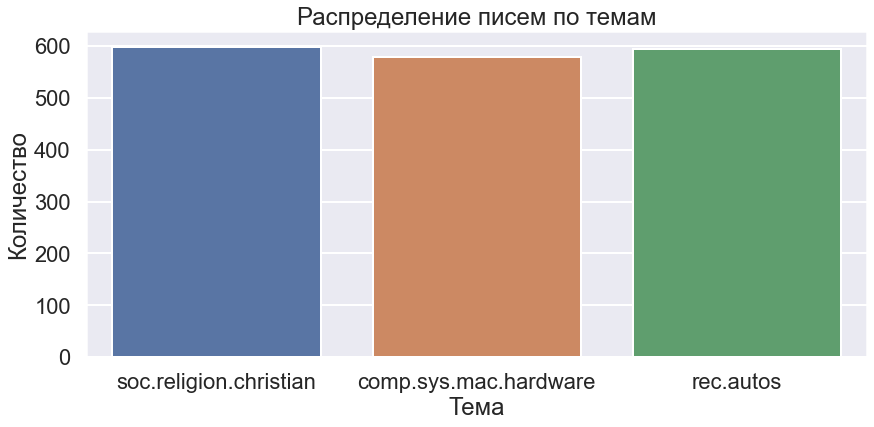

In [395]:
sns.set_context('poster')
plt.figure(figsize=(14, 6))
ax = sns.countplot(x=news_target_names)
ax.set(xlabel ='Тема', ylabel ='Количество', 
       title ='Распределение писем по темам');

Темы распределены почти равномерно.

### Предобработка текста

Посмотрим на первые 3 письма.

In [396]:
for i in range(3):
    print(f'Тема: {news_target_names[i]}\n\n{news_data[i]}')
    print('---------------------------------------------')

Тема: soc.religion.christian

From: Rick_Granberry@pts.mot.com (Rick Granberry)
Subject: Pastoral Authority
Reply-To: Rick_Granberry@pts.mot.com (Rick Granberry)
Organization: Motorola Paging and Telepoint Systems Group
Lines: 17

There is some controversy in my denomination as to what authority is vested 
in the pastor.  I am still forming my opinion.  I am solicing opinions, and 
references for what that is, how much, and how it should be used.

   As a general reference, I would not exclude responses from different 
denominations based on Biblical teachings, but you have to understand our 
church is independent, protestant and likely to be much different from those 
that follow ecclesiastical authority in the church.  We may need to discuss 
the roles of deacons and elders.

Thanks for your replies.



| "Answer not a fool according to his folly, lest thou also be like unto him." |
| "Answer a fool according to his folly, lest he be wise in his own conceit."  |
| (proverbs 26:4&5)



Как мы видим, тексты содержат много лишних символов, которые необходимо отфильтровать.
Для преобразования сырого текста будем использовать библиотеку __[NLTK](https://www.nltk.org/) (Natural Language Toolkit)__, которая является ведущей платформой для создания NLP-программ. 

Разобъем исходный текст на токены с приминением __лемматизации__$^2$. Для этого реализуем класс `LemmaTokenizer`, объект которого будем далее передавать в функцию [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), вычисляющую $\text{TF-IDF}$ для каждого слова.

$^2 - $ лемматизация - получение начальной формы слова.

In [182]:
# Интерфейс токенизатора от nltk с sklearn
class LemmaTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`', '&', "'", 
                     '-']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) 
                for t in regexp_tokenize(doc, r'[a-zA-Z]{2,}') 
                if t not in self.ignore_tokens]

Также из текста будут удалены __стоп-слова__ — это частовстречаемые слова в языке, которые не несут смысловую нагрузку.

Используется регулярное выражение `'[a-zA-Z]{2,}'` для выделения только тех слов, которые состоят из букв и длиной не меньше 2.

In [270]:
# Инициализация объекта класса
tokenizer = LemmaTokenizer()
# Формирирование множества стоп-слов
stop_words = set(stopwords.words('english')) 
token_stop = tokenizer(' '.join(stop_words))

# Создание TF-IDF модели
vectorizer = TfidfVectorizer(stop_words=token_stop, 
                             tokenizer=tokenizer,
                             ngram_range=(1, 2), # Испрользуем униграммы и биграммы слов
                             max_df=0.6, # Игнорируем слова, частота встречания которых в тексте >= 60% 
                             min_df=30 # Игнорируем слова, встречающиеся реже 30 раз
                            )
# Получение матрицы признаков
doc_vectors = vectorizer.fit_transform(news_data)

Такие 'жесткие' требования по частотности необходимы для того, чтобы признаков получилось меньше. Это связано с проблемой 'Проклятия размерности', из-за которой алгоритмы кластеризации будут работать хуже. Посмотрим на получившуюся размерность матрицы признаков.

In [271]:
doc_vectors.shape

(1771, 1270)

Мы получили $1270$ признаков для $1771$ текстов.

### Метод K-Means (K средних)

In [1028]:
doc_vectors.toarray().min()

0.0

Алгоритм __K-means__ представляет собой итеративный процесс. Пусть в начале произвольным образом выбраны центры классов. Объект относится к тому кластеру, расстояние до центра которого меньше. На каждой итерации сначала пересчитываются положения центра каждого класса как среднее арифметическое отнесенных к нему точек, а после этого объекты перераспределяются на основании новых положений центров.

In [273]:
# Инициализация модели с 3 кластерами
k_means = KMeans(n_clusters=3,
                 random_state=RANDOM_SEED,
                 n_init=20)
# Обучение и получение предсказаний
preds_km = k_means.fit_predict(doc_vectors)

Здесь: 
- `random_state` полностью определяет случайные значения, которые используются в методе K-means.
- `n_init` количество раз выполнения алгоритма k-средних с различными расположениями центроидов.

In [274]:
print(preds_km) # Результат кластеризации 
print(news_target) # Истинные ответы

[1 0 0 ... 2 0 0]
[2 0 1 ... 1 1 0]


Соответствие между метками тем и номерами кластеров могло измениться, поэтому имеет смысл перебрать все возможные соответствия (найдем все перестановки в группе $S_3$):

In [275]:
def validate_with_mappings(preds, target):
    permutations = itertools.permutations([0, 1, 2]) 
    for a, b, c in permutations:
        mapping = {0 : a, 1: b, 2: c}
        mapped_preds = [mapping[pred] for pred in preds]
        print(float(sum(mapped_preds != target)) / len(target),
              ' - ', mapping)

In [276]:
validate_with_mappings(preds_km, news_target)

0.6758893280632411  -  {0: 0, 1: 1, 2: 2}
0.06324110671936758  -  {0: 0, 1: 2, 2: 1}
0.9616036137775268  -  {0: 1, 1: 0, 2: 2}
0.6437041219649915  -  {0: 1, 1: 2, 2: 0}
0.6804065499717674  -  {0: 2, 1: 0, 2: 1}
0.9751552795031055  -  {0: 2, 1: 1, 2: 0}


В случае лучшей перестановки мы получаем $6\%$ ошибок.

In [247]:
mapping = {0: 0, 1: 2, 2: 1}
preds_km = [mapping[pred] for pred in preds_km]

Посмотрим, какие слова внесли наибольшую значимость для кластеров. Для этого отсортируем признаки по их важности для каждого центроида.

In [416]:
main_words_idx = np.argsort(k_means.cluster_centers_)[:, :-10:-1]
main_words_values = np.sort(k_means.cluster_centers_)[:, :-10:-1]

Визуализируем для каждого кластера слова в виде облака слов$^3$.

$^3 $ [облако слов](https://ru.wikipedia.org/wiki/Облако_тегов) — это визуальное представление взвешенного списка категорий

In [417]:
# Самые значимые слова кластеров
main_words = []
for row in main_words_idx:
    main_words.append([vectorizer.get_feature_names()[idx] for idx in row])

In [418]:
# Уровень значимости для каждого слова
main_words_values = np.ceil(main_words_values * 1000).astype(int)

In [419]:
# Массив взвешенных текстов на основе значимых слов и их весов
weighted_texts = []
for row_word, row_weight in zip(main_words, main_words_values):
    words = []
    for word, weight in zip(row_word, row_weight):
        words += [word] * weight
    weighted_texts.append(' '.join(words))

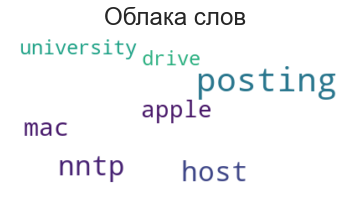

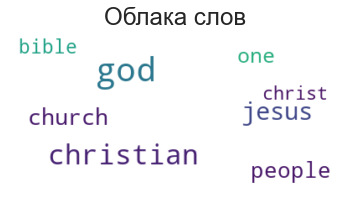

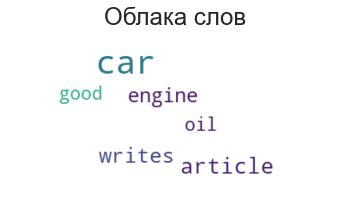

In [420]:
for weighted_text in weighted_texts:
    wordcloud = WordCloud(max_font_size=40, background_color='white',
                          max_words=10000, collocations=False,
                          random_state=RANDOM_SEED
                          )
    
    wordcloud = wordcloud.generate(weighted_text)
    plt.figure()
    plt.title('Облака слов')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

На первом графике мы видим, например, слово `apple` и слово `mac`, которые характерны для писем на тему `comp.sys.mac.hardware`.

На втором графике самые важные признаки (слова) кластера это: `god`, `christian`, `church`. Понятно, что данный кластер относится к теме `soc.religion.christian`.

И, наконец, на 3-м графике ярко выражены слова, которые представляют тему `rec.autos`, такие как: `car`, `engine`, `oil`.

Нельзя отрицать, что есть и слова, которые не относятся явно к той или иной теме: `good`, `article`, `one`.

### Автоматическое определение числа кластеров

В рассмотренном выше примере мы заранее знали число кластеров, но в изначальной задаче мы этого не знаем. Для подбора оптимального количества кластеров воспользуемся коэффициентом силуэта. Коэффициент силуэта для некоторого фиксированного объекта определяется следующим образом:

$$\text{silhouette} = \frac{b-a}{max(a,b)},$$

где $a$ — среднее расстояние от данного объекта до других объектов из того же кластера, $b$ — среднее расстояние от данного объекта до объектов из ближайшего другого кластера.
Обычно коэффициент силуэта положителен, но, вообще говоря, может меняться в пределах от $−1$ до $1$.

Будем перебирать число кластеров от $2$ до $10$ и считать значение силуэта.

In [1032]:
km_silhouette = []


for i in range(2, 11):
    km = KMeans(n_clusters=i, random_state=RANDOM_SEED).fit(doc_vectors)
    preds = km.predict(doc_vectors)
    
    silhouette = silhouette_score(doc_vectors, preds)
    km_silhouette.append(silhouette)
    print("Значение силуэта для числа кластеров {}: {}".format(i, silhouette))

Значение силуэта для числа кластеров 2: 0.0170241194155263
Значение силуэта для числа кластеров 3: 0.018327373069654034
Значение силуэта для числа кластеров 4: 0.019146397092015165
Значение силуэта для числа кластеров 5: 0.018972795978649013
Значение силуэта для числа кластеров 6: 0.014071564254867192
Значение силуэта для числа кластеров 7: 0.01645955214965591
Значение силуэта для числа кластеров 8: 0.015403487343478314
Значение силуэта для числа кластеров 9: 0.01749722696202777
Значение силуэта для числа кластеров 10: 0.01930070346410966


Далее пострим график зависимости значения силуэта от числа кластеров.

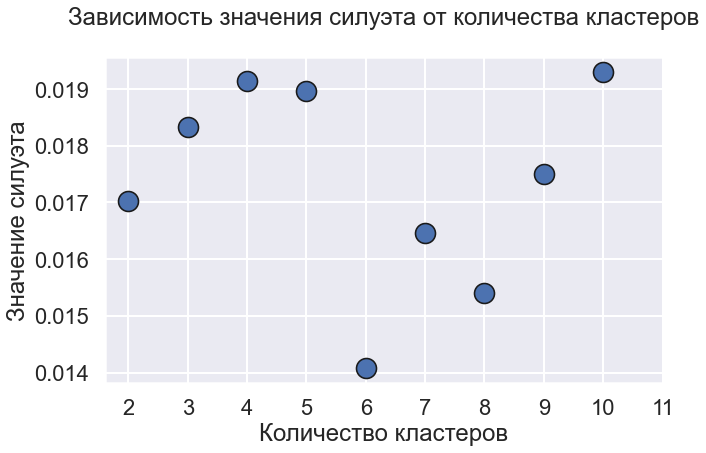

In [1045]:
sns.set_context('poster')
plt.figure(figsize=(10, 6))
plt.title("Зависимость значения силуэта от количества кластеров\n")
sns.scatterplot(x=[i for i in range(2, 11)], y=km_silhouette,
                s=400, edgecolor='k')
plt.grid(True)
plt.xlabel("Количество кластеров")
plt.ylabel("Значение силуэта")
plt.xticks([i for i in range(2,12)])
plt.show()

В качестве оптимального количества кластеров выбирается то количество, которое дает максимальное значение коэффициента силуэта. Мы видим, что лучшее количество кластеров получилось равно 10. Проанализируем метод с таким числом кластеров.

In [1046]:
k_means_10 = KMeans(n_clusters=10,
                    random_state=RANDOM_SEED,
                    n_init=20)

preds_km_10 = k_means_10.fit_predict(doc_vectors)

In [1049]:
main_words_10_idx = np.argsort(k_means_10.cluster_centers_)[:, :-20:-1]
main_words_10_values = np.sort(k_means_10.cluster_centers_)[:, :-20:-1]

# Самые значимые слова кластеров
main_words_10 = []
for row in main_words_10_idx:
    main_words_10.append([vectorizer.get_feature_names()[idx] for idx in row])
    
# Уровень значимости для каждого слова
main_words_10_values = np.ceil(main_words_10_values * 1000).astype(int)

# Массив взвешенных текстов на основе значимых слов и их весов
weighted_10_texts = []
for row_word, row_weight in zip(main_words_10, main_words_10_values):
    words = []
    for word, weight in zip(row_word, row_weight):
        words += [word] * weight
    weighted_10_texts.append(' '.join(words))
    

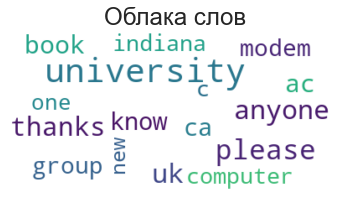

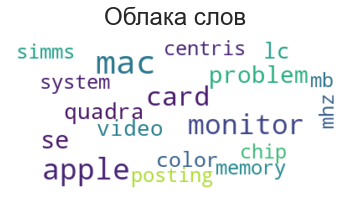

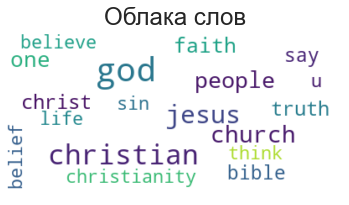

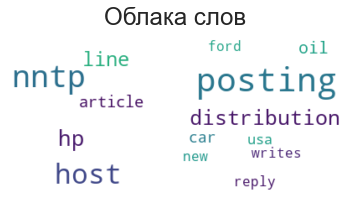

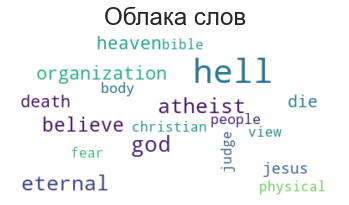

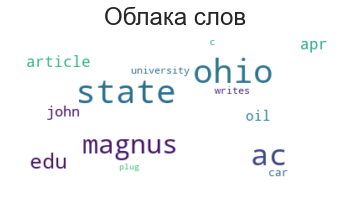

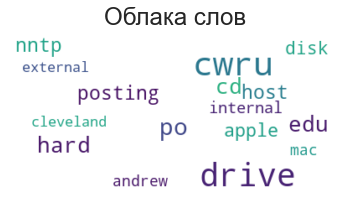

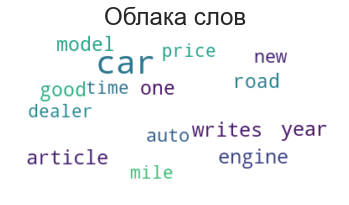

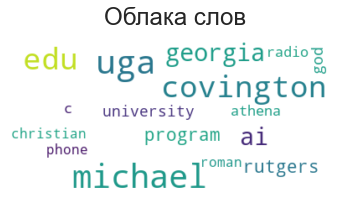

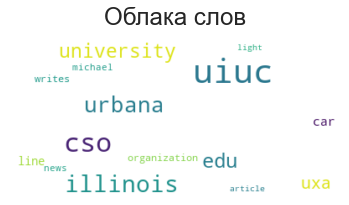

In [1050]:
for weighted_text in weighted_10_texts:
    wordcloud = WordCloud(max_font_size=40, background_color='white',
                          max_words=10000, collocations=False,
                          random_state=RANDOM_SEED
                          )
    
    wordcloud = wordcloud.generate(weighted_text)
    plt.figure()
    plt.title('Облака слов')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Многие кластеры получились вполне репрезентативны.

## Определение тональности

### Векторное представление слов

Первым делом необходимо представить данные в векторном пространстве. Для этого воспользуемся подходом `Word2Vec`. Данный алгоритм создает векторное пространство слов на основе нейронных сетей. Каждое слово представляется в построенном векторном пространстве. Главное свойство данного метода заключается в важности контекстной близости слов, которое выражается в косинусном сходстве, которое считается как косинус угла между векторами:
$$\text{Similarity}(\vec{\text{Word}_1}, \vec{\text{Word}}_2)=\cos(\langle \vec{\text{Word}_1}, \vec{\text{Word}}_2 \rangle)=\frac{\vec{\text{Word}_1} * \vec{\text{Word}_2} }{||\vec{\text{Word}_1}|| * ||\vec{\text{Word}_2}||}$$ 

Обучение модели `Word2Vec` требует большой вычислительной мощности и огромного количества данных, поэтому возьмем предобученную модель. Для этого воспользуемся готовой моделью, которую подготовила команда ["RusVectōrēs"](https://rusvectores.org/ru/about/). Модель под названем `news_upos_skipgram_300_5_2019` имеет следующие особенности:


|Название характеристики|Значение|
|:-|:-|
|Корпус для обучения| Русскоязычные новости$^4$|
| Размер корпуса| $2.6$ миллиарда слов
| Объем словаря| $249318$
| Тагсет| Universal Tags
| Алгоритм| Continuous Skipgram
| Размерность вектора| $300$
| Размер окна| $5$


$^4$ - Поток новостей с $1500$ преимущественно русскоязычных новостных сайтов (около $30$ миллионов документов);


Для возможности работы с предобученной моделью необходимо, чтобы данные, которые подаются на вход модели, были в том же формате, что и данные, на которых эта модель была натренирована.



Предобработка текстов для тренировки моделей осуществлялась следующим образом:

- лемматизация и удаление стоп-слов;
- приведение лемм к нижнему регистру;
- добавление частеречного тэга для каждого слова.

Для предобработки авторы модели предлагают использовать [UDPipe](https://ufal.mff.cuni.cz/udpipe), чтобы сразу получить частеречную разметку в виде Universal POS-tags.
UDPipe использует предобученные модели для лемматизации и тэггинга.

In [427]:
udpipe_url = 'https://rusvectores.org/static/models/udpipe_syntagrus.model'

modelfile = wget.download(udpipe_url)

Перед лемматизацией и тэггингом, модели были очищены от пунктуации и возможных ошибок при помощи фильтров [Татьяны Шавриной](https://github.com/TatianaShavrina/taiga).

In [513]:
def num_replace(word):
    newtoken = 'x' * len(word)
    return newtoken


def clean_token(token, misc):
    out_token = token.strip().replace(' ', '')
    if token == 'Файл' and 'SpaceAfter=No' in misc:
        return None
    return out_token


def clean_lemma(lemma, pos):
    out_lemma = lemma.strip().replace(' ', '').replace('_', '').lower()
    if '|' in out_lemma or out_lemma.endswith('.jpg') 
                        or out_lemma.endswith('.png'):
        return None
    if pos != 'PUNCT':
        if out_lemma.startswith('«') or out_lemma.startswith('»'):
            out_lemma = ''.join(out_lemma[1:])
        if out_lemma.endswith('«') or out_lemma.endswith('»'):
            out_lemma = ''.join(out_lemma[:-1])
        if out_lemma.endswith('!') or out_lemma.endswith('?') 
                                   or out_lemma.endswith(',') \
                                   or out_lemma.endswith('.'):
            out_lemma = ''.join(out_lemma[:-1])
    return out_lemma


def list_replace(search, replacement, text):
    search = [el for el in search if el in text]
    for c in search:
        text = text.replace(c, replacement)
    return text


def unify_sym(text):  # принимает строку в юникоде
    text = list_replace(
        "\u00AB\u00BB\u2039\u203A\u201E\u201A\u201C\u201F\u2018\u201B\u201D\u2019",
        "\u0022",
        text,
    )

    text = list_replace(
        "\u2012\u2013\u2014\u2015\u203E\u0305\u00AF", "\u2003\u002D\u002D\u2003", 
        text
    )

    text = list_replace("\u2010\u2011", "\u002D", text)

    text = list_replace(
        "\u2000\u2001\u2002\u2004\u2005\u2006\u2007\u2008\u2009\u200A\u200B\u202F\u205F\u2060\u3000",
        "\u2002",
        text,
    )

    text = re.sub("\u2003\u2003", "\u2003", text)
    text = re.sub("\t\t", "\t", text)

    text = list_replace(
        "\u02CC\u0307\u0323\u2022\u2023\u2043\u204C\u204D\u2219\u25E6\u00B7\u00D7\u22C5\u2219\u2062",
        ".",
        text,
    )

    text = list_replace("\u2217", "\u002A", text)

    text = list_replace("…", "...", text)

    text = list_replace("\u2241\u224B\u2E2F\u0483", "\u223D", text)

    text = list_replace("\u00C4", "A", text)
    text = list_replace("\u00E4", "a", text)
    text = list_replace("\u00CB", "E", text)
    text = list_replace("\u00EB", "e", text)
    text = list_replace("\u1E26", "H", text)
    text = list_replace("\u1E27", "h", text)
    text = list_replace("\u00CF", "I", text)
    text = list_replace("\u00EF", "i", text)
    text = list_replace("\u00D6", "O", text)
    text = list_replace("\u00F6", "o", text)
    text = list_replace("\u00DC", "U", text)
    text = list_replace("\u00FC", "u", text)
    text = list_replace("\u0178", "Y", text)
    text = list_replace("\u00FF", "y", text)
    text = list_replace("\u00DF", "s", text)
    text = list_replace("\u1E9E", "S", text)

    currencies = list(
        "\u20BD\u0024\u00A3\u20A4\u20AC\u20AA\u2133\u20BE\u00A2\u058F\u0BF9\u20BC\u20A1\u20A0\u20B4\u20A7\u20B0\u20BF\u20A3\u060B\u0E3F\u20A9\u20B4\u20B2\u0192\u20AB\u00A5\u20AD\u20A1\u20BA\u20A6\u20B1\uFDFC\u17DB\u20B9\u20A8\u20B5\u09F3\u20B8\u20AE\u0192"
    )

    alphabet = list(
        '\t\n\r абвгдеёзжийклмнопрстуфхцчшщьыъэюяАБВГДЕЁЗЖИЙКЛМНОПРСТУФХЦЧШЩЬЫЪЭЮЯ,.[]{}()=+-−*&^%$#@!?~;:0123456789§/\|"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ '
    )

    alphabet.append("'")

    allowed = set(currencies + alphabet)

    cleaned_text = [sym for sym in text if sym in allowed]
    cleaned_text = "".join(cleaned_text)

    return cleaned_text

Приступим к предобработке текста. Её можно настроить для своей задачи. Если частеречные тэги нам не нужны, в функции мы можем выставить `keep_pos=False`. Если нам необходимо сохранить знаки пунктуации, выставим `keep_punct=True`.

In [535]:
def process(pipeline, text='Строка', keep_pos=True, keep_punct=False):
    entities = {'PROPN'}
    named = False
    memory = []
    mem_case = None
    mem_number = None
    tagged_propn = []

    # обрабатываем текст, получаем результат в формате conllu:
    processed = pipeline.process(text)

    # пропускаем строки со служебной информацией:
    content = [l for l in processed.split('\n') if not l.startswith('#')]

    # извлекаем из обработанного текста леммы, тэги и морфологические характеристики
    tagged = [w.split('\t') for w in content if w]

    for t in tagged:
        if len(t) != 10:
            continue
        (word_id, token, lemma, pos, xpos, feats, head, deprel, deps, misc) = t
        token = clean_token(token, misc)
        lemma = clean_lemma(lemma, pos)
        if not lemma or not token:
            continue
        if pos in entities:
            if '|' not in feats:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            morph = {el.split('=')[0]: el.split('=')[1] for el in feats.split('|')}
            if 'Case' not in morph or 'Number' not in morph:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            if not named:
                named = True
                mem_case = morph['Case']
                mem_number = morph['Number']
            if morph['Case'] == mem_case and morph['Number'] == mem_number:
                memory.append(lemma)
                if 'SpacesAfter=\\n' in misc or 'SpacesAfter=\s\\n' in misc:
                    named = False
                    past_lemma = '::'.join(memory)
                    memory = []
                    tagged_propn.append(past_lemma + '_PROPN')
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN')
                tagged_propn.append('%s_%s' % (lemma, pos))
        else:
            if not named:
                if pos == 'NUM' and token.isdigit():  # Заменяем числа на xxxxx той же длины
                    lemma = num_replace(token)
                tagged_propn.append('%s_%s' % (lemma, pos))
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN')
                tagged_propn.append('%s_%s' % (lemma, pos))

    if not keep_punct:
        tagged_propn = [word for word in tagged_propn if word.split('_')[1] != 'PUNCT']
    if not keep_pos:
        tagged_propn = [word.split('_')[0] for word in tagged_propn]
    return tagged_propn

Теперь загружаем модель `UDPipe`. Текст, который передается модели, токенизируется, лемматизируется и размечается по частям речи с использованием UDPipe. На выход подаётся последовательность разделенных пробелами лемм с частями речи.

In [538]:
model_UDP = Model.load('udpipe_syntagrus.model')

In [539]:
def tag_ud(text='Текст нужно передать функции в виде массива!'):
    process_pipeline = Pipeline(model_UDP, 'tokenize',
                                Pipeline.DEFAULT,
                                Pipeline.DEFAULT, 'conllu')

    text = unify_sym(text.strip())
    processed_text = process(process_pipeline, text=text)
    
    return processed_text

Возьмем в качестве примера текста новости с Telegram-канала РИА новости.

In [1275]:
ria_news = pd.read_csv('data/ria.csv', names=['Text', 'Date'], parse_dates=['Date'])
ria_news['Date'] = ria_news['Date'].dt.date

In [1166]:
text = ria_news['Text'][4]
print(text)

Поддержка Черногорией санкций Запада в отношении России была ошибкой, заявил РИА Новости один из лидеров оппозиции, которая выиграла парламентские выборы


Применим к данному тексту нашу функцию.

In [542]:
tag_ud(text)

['поддержка_NOUN',
 'черногориий_PROPN',
 'санкция_NOUN',
 'запад_PROPN',
 'в_ADP',
 'отношение_NOUN',
 'россия_PROPN',
 'быть_AUX',
 'ошибка_NOUN',
 'заявлять_VERB',
 'риа_PROPN',
 'новость_PROPN',
 'один_NUM',
 'из_ADP',
 'лидер_NOUN',
 'оппозиция_NOUN',
 'который_PRON',
 'выигрывать_VERB',
 'парламентский_ADJ',
 'выборы_NOUN']

Рассмотрим еще один пример

In [572]:
text = ria_news['Text'][13]
print(text)

Российский посол в Белоруссии сегодня учил студентов минского филиала РГСУ китайскому языку. И рисовал лошадь.


In [573]:
tag_ud(text)

['российский_ADJ',
 'посол_NOUN',
 'в_ADP',
 'белоруссия_PROPN',
 'сегодня_ADV',
 'учить_VERB',
 'студент_NOUN',
 'минский_ADJ',
 'филиал_NOUN',
 'ргс_PROPN',
 'китайский_ADJ',
 'язык_NOUN',
 'и_CCONJ',
 'рисовать_VERB',
 'лошадь_NOUN']

Далее загрузим скаченную модель, которая находится в формате `.bin`. Для загрузки модели в формате `word2vec` в классе `KeyedVectors` существует функция `load_word2vec_format`, а бинарность модели можно указать в аргументе `binary`.

In [530]:
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('model/model.bin',
                                                            binary=True)

Возьмем несколько обработанных слов и найдем для каждого 5 самых приближенных относительного косинусного расстояния токенов для него. Везуализируем полученные вектора с помощью алгоритма понижения размерности $\text{t-SNE}$ (t-distributed Stochastic Neighbor Embedding). 

In [585]:
w2v_model.most_similar(positive=['филиал_NOUN'], topn=5)

[('александр::перевалов_PROPN', 0.5577623248100281),
 ('алексей::стрельченко_PROPN', 0.5473641157150269),
 ('втб::вадим::григорьев_PROPN', 0.5350966453552246),
 ('валентина::гашкова_PROPN', 0.5346050262451172),
 ('иванцевичский_ADJ', 0.5209556818008423)]

In [586]:
words = ['выборы_NOUN', 'выигрывать_VERB', 'заявлять_VERB', 'лошадь_NOUN', 
         'сегодня_ADV', 'студент_NOUN']

In [615]:
def tsne_plot(labels, tokens, classes, clusters):
    tsne_model = TSNE(perplexity=5, n_components=2, init='pca', n_iter=3500,
                      random_state=RANDOM_SEED)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []

    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    colors = cm.rainbow(np.linspace(0, 1, clusters))
    plt.figure(figsize=(16, 9))
    for i in range(len(x)):
        plt.scatter(x[i], y[i], c=colors[classes[i]].reshape(1,-1),
                    alpha=0.75)
        plt.annotate(labels[i], alpha=0.75, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', 
                     va='bottom', size=10)
    plt.grid(True)
    plt.title('Визуализация кластеров похожих слов с использование t-SNE',
              fontsize=30)
    plt.show()

Попросим у модели 5 ближайших соседей для каждого слова и коэффициент косинусной близости для каждого:

In [599]:
labels = []
tokens = []
classes = []

samples = 6
for i, word in enumerate(words):
    tokens.append(w2v_model[word])
    labels.append(word)
    classes.append(i)
    for similar_word, similarity in w2v_model.most_similar(word, topn=5):
        tokens.append(w2v_model[similar_word])
        labels.append(similar_word)
        classes.append(i)

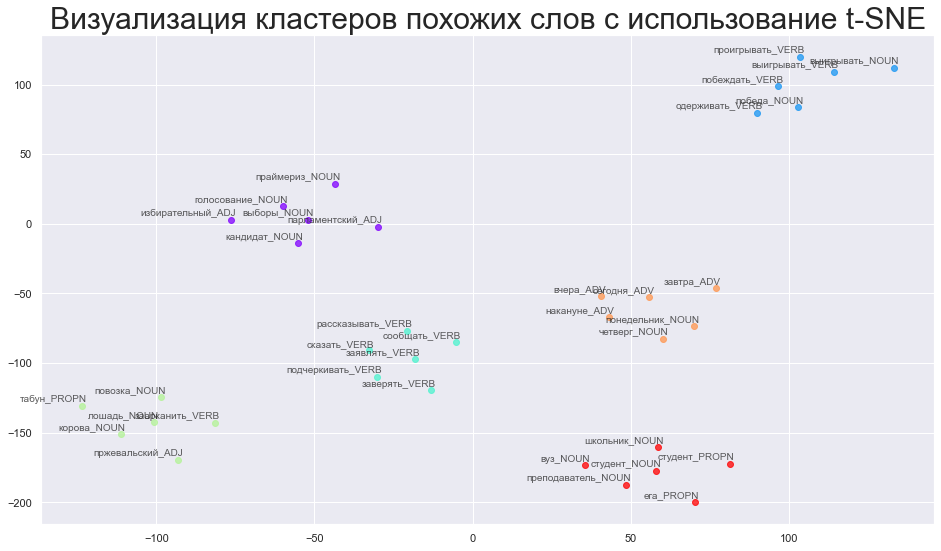

In [616]:
tsne_plot(labels, tokens, classes, samples)

Мы видим, что модель `Word2Vec` эффективно отделяет несвязные слова и объединяет связные.

### Обучение моделей

Для обучения возьмем следующие данные:

|Датасет|Описание|Классы|Ссылка|
|--|:--:|--|--|
|LINIS Crowd|Открытый набор с примерами настроений, собранный из социальных и политических статей на сайтах различных СМИ|5|[Старница проекта](http://www.linis-crowd.org/)
|RuTweetCorp|Крупнейший, автоматически аннотируемый, открытый корпус текстов с небольшим ручным фильтрованием. Собран автоматически из русскоязычного Twitter|2|[Старница проекта](https://study.mokoron.com/)
|Kaggle Russian News Dataset|Открытый набор с примерами настроений из российских новостей|3|[Страница на Kaggle](https://www.kaggle.com/c/sentiment-analysis-in-russian)


Мы будем решать задачу классификации на 2 класса: `Агрессивный` (-1), `Позитивный` (1). Поэтому все данные нужно соединить так, чтобы получился размеченный на 2 класса сбалансированный датасет. 

In [756]:
linis_crowd = pd.read_excel('data/text_rating_final.xlsx', header=None,
                            names=['Text', 'Label'], usecols=[0, 1], 
                            dtype={'Label': 'Int64'})
linis_crowd['Label'] = linis_crowd.apply(lambda x: -1 if x.Label < -1 else 
                                         (1 if x.Label > 1 else x.Label),
                                        axis=1)
linis_crowd = linis_crowd[linis_crowd['Label'] != 0]

In [757]:
ru_tweet_corp_pos = pd.read_csv('data/RuTweetCorp_pos.csv', sep=';',
                                header=None, names=['Text'], usecols=[3])
pos_labels = np.empty(ru_tweet_corp_pos.shape[0])
pos_labels.fill(1)
ru_tweet_corp_pos['Label'] = pos_labels

ru_tweet_corp_neg = pd.read_csv('data/RuTweetCorp_neg.csv', sep=';',
                                header=None, names=['Text'], usecols=[3])
neg_labels = np.empty(ru_tweet_corp_neg.shape[0])
neg_labels.fill(-1)
ru_tweet_corp_neg['Label'] = neg_labels

In [760]:
kaggle_rus_news = pd.read_json('data/Kaggle_Russian_News_Dataset.json')
kaggle_rus_news = kaggle_rus_news[['text', 'sentiment']] \
                  .rename(columns={'text': 'Text', 'sentiment': 'Label'})
kaggle_rus_news['Label'] = kaggle_rus_news\
                           .apply(lambda x: -1 if x.Label == 'negative' else 
                                  (1 if x.Label == 'positive' else 0),
                                  axis=1)
kaggle_rus_news = kaggle_rus_news[kaggle_rus_news['Label'] != 0]

In [794]:
all_data = pd.concat([linis_crowd, ru_tweet_corp_pos, 
                      ru_tweet_corp_neg, kaggle_rus_news], ignore_index=True)
all_data = all_data.dropna(axis='rows')

Посмотрим на распределение классов.

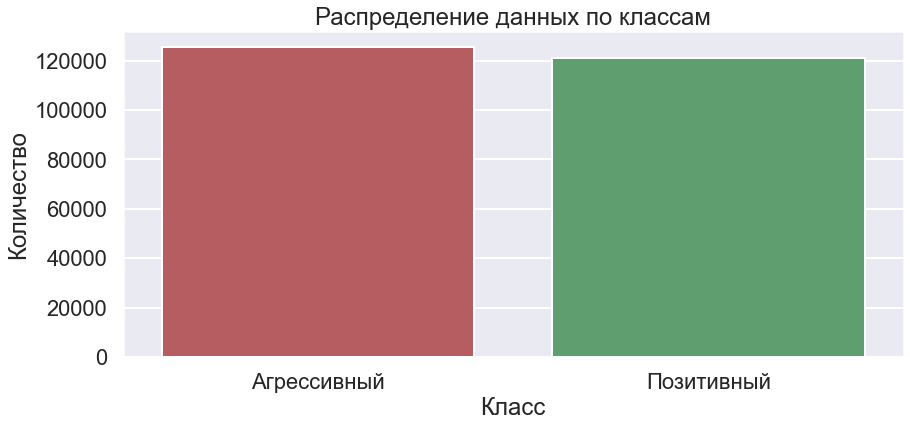

In [1142]:
sns.set_context('poster')
plt.figure(figsize=(14, 6))
ax = sns.countplot(x=all_data.Label, palette=['r', 'g'])
ax.set(xlabel ='Класс', ylabel ='Количество', 
       title ='Распределение данных по классам')
plt.xticks([0, 1], ['Агрессивный', 'Позитивный']);

Выборка получилась сбалансированной.

#### Разделение данных для обучения и тестирования

Так как данных достаточно много, то можно взять $20\%$ для теста. 

In [897]:
test_size = 0.2

train, test = train_test_split(
    all_data,
    test_size=test_size,
    random_state=RANDOM_SEED,
)
        
X_train = train['Text'].values
X_test = test['Text'].values
y_train = train['Label'].values
y_test = test['Label'].values

#### Нижняя граница производительности

Моделирование лучше всего начинать с самой простой из возможных моделей. Одной из таких моделей является присвоение случайной метки (0 или 1) с вероятностью, оцениваемой по распределению классов в обучающем наборе.

В качестве признаков мы можем просто использовать нули.

In [798]:
X_train_zero = np.zeros((len(train), 1))
X_test_zero = np.zeros((len(test), 1))

dummy_clf = DummyClassifier(
    strategy='stratified',
    random_state=RANDOM_SEED, 
).fit(X_train_zero, y_train)

In [799]:
y_pred_dummy = dummy_clf.predict(X_test_zero)

In [800]:
dummy_acc = accuracy_score(y_test, y_pred_dummy)
print("Доля правильных ответов Dummy классификатора: {:5f}".format(dummy_acc))

Доля правильных ответов Dummy классификатора: 0.495852


Точность получилась примерно $0.5$, так как выборка сбалансирована

Чтобы лучше понять проблему, мы можем построить матрицу неточностей.

In [803]:
dummy_cnf_mat = confusion_matrix(y_test, y_pred_dummy)

In [838]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Метрица неточностей',
                          cmap=plt.cm.Reds):
    """
    Данная функция печатает и строит матрицу неточностей.
    Нормализация может применяться при установке нормализуют=правда`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.set_context('poster')
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)
    fmt = '.6f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.ylabel('Истинное значение')
    plt.xlabel('Предсказанное значение')
    plt.tight_layout()
    plt.grid(None)

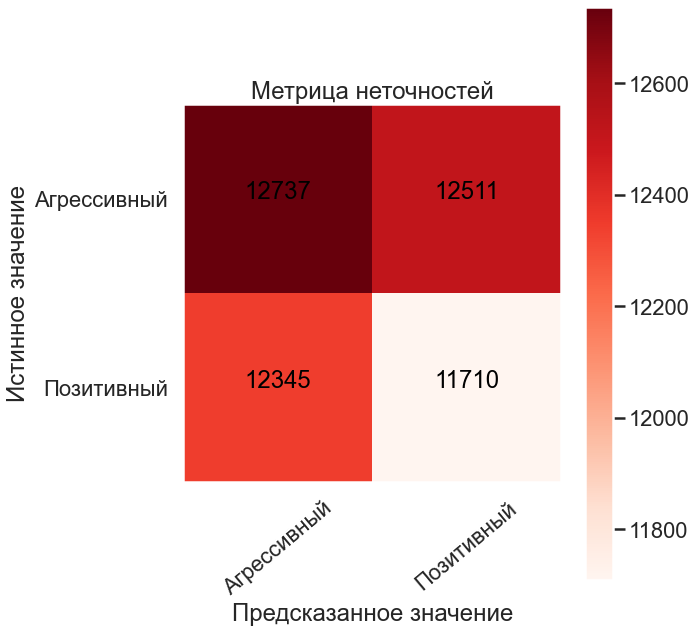

In [1143]:
plot_confusion_matrix(
    dummy_cnf_mat,
    ['Агрессивный', 'Позитивный'],
)

Матрица неточностей ясно показывает, что число ложных срабатываний и ложных отрицаний примерно такое же, как и число истинных срабатываний для отрицательного класса.

Чтобы формализовать эту пропорцию, рассмотрим следующие бинарные классификационные метрики:

Precision
$$P = \frac{TP}{TP + FP}$$
Recall

$$R = \frac{TP}{TP + FN}$$
F-мера
$$F_1 = \frac{2PR}{P + R}$$

In [1144]:
classes = ['Агрессивный', 'Позитивный']
dummy_clf_report = classification_report(
    y_test,
    y_pred_dummy,
    target_names=classes,
)
print(dummy_clf_report)

              precision    recall  f1-score   support

 Агрессивный       0.51      0.50      0.51     25248
  Позитивный       0.48      0.49      0.49     24055

    accuracy                           0.50     49303
   macro avg       0.50      0.50      0.50     49303
weighted avg       0.50      0.50      0.50     49303



Усреднение метрик дает результат $0.5$

#### Формируем данные

Алгоритм `Word2Vec` векторизует только отдельные токены, поэтому сначала необходимо их векторизовать по отдельности и потом объединить вектора слов в один, который и будет является вектором целого новостного поста. Самым оптимальным вариантом является подсчет среднего вектора из набора. 

In [876]:
def buildWordVector(text, size):
    vec = np.zeros(size)
    count = 0.
    for word in tag_ud(text):
        try:
            vec += w2v_model[word]
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

In [927]:
n_dim = 300
X_train_vec = []

for text in tqdm(X_train):
    X_train_vec.append(buildWordVector(text, n_dim))

X_train_vec = np.array(X_train_vec)

100%|██████████| 197211/197211 [2:35:21<00:00, 21.16it/s]   


In [929]:
X_test_vec = []

for text in tqdm(X_test):
    X_test_vec.append(buildWordVector(text, n_dim))

X_test_vec = np.array(X_test_vec)

100%|██████████| 49303/49303 [41:22<00:00, 19.86it/s]   


Сохраним преобразованные тексты в `.csv` формате.

In [930]:
pd.DataFrame(X_train_vec).to_csv('data/train.csv', index=False)

In [932]:
pd.DataFrame(X_test_vec).to_csv('data/test.csv', index=False)

#### Масштабирование данных

Многие модели чувствительны к масштабу признаков, поэтому ограничим диапозон значений в отрезке $[0, 1]$

In [944]:
scaler = MinMaxScaler()
scaler.fit(X_train_vec)
X_train_scaled = scaler.transform(X_train_vec)
X_test_scaled = scaler.transform(X_test_vec)

In [963]:
print(f'Минимальное значение в train: {X_train_scaled.min()}\nМаксимальное значение в train: {X_train_scaled.max()}')

Минимальное значение в train: 0.0
Максимальное значение в train: 1.0


#### Логичстическая регрессия

Данный алгоритм является разумным первым выбором для быстрого получения нетривиального решения.

Давайте обучим модель с помощью этого алгоритма с параметрами по умолчанию.

In [966]:
%%time

logreg = LogisticRegression(random_state=RANDOM_SEED, max_iter=500)\
                           .fit(X_train_scaled, y_train)

CPU times: user 1min 6s, sys: 1.02 s, total: 1min 7s
Wall time: 34.5 s



Теперь мы можем получить прогнозы для тестового набора.

In [967]:
y_pred_logreg = logreg.predict(X_test_scaled)


Ниже приведены оценочные показатели для обоих классов:

In [971]:
logreg_clf_report = classification_report(y_test, y_pred_logreg,
                                          target_names=classes)
print(logreg_clf_report)

              precision    recall  f1-score   support

  Агресивный       0.66      0.68      0.67     25248
  Позитивный       0.65      0.63      0.64     24055

    accuracy                           0.66     49303
   macro avg       0.66      0.66      0.66     49303
weighted avg       0.66      0.66      0.66     49303



По сравнению с базовой моделью эта модель показывает лучшие результаты для положительного класса, а также и для отрицательного класса, однако всего на $16\%$.

Посмотрим на $\text{ROC}-$кривую модели.

In [1002]:
def plot_roc_curve(y_true, y_pred, ax=None, pos_label=None, **kwargs):

    sns.set_context('poster')
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=pos_label)

    if ax is None:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(1,1,1)

    ax.step(fpr, tpr, where='post', **kwargs)
    ax.legend()
    ax.plot([0, 1], [0, 1], linestyle='--', color='k')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')

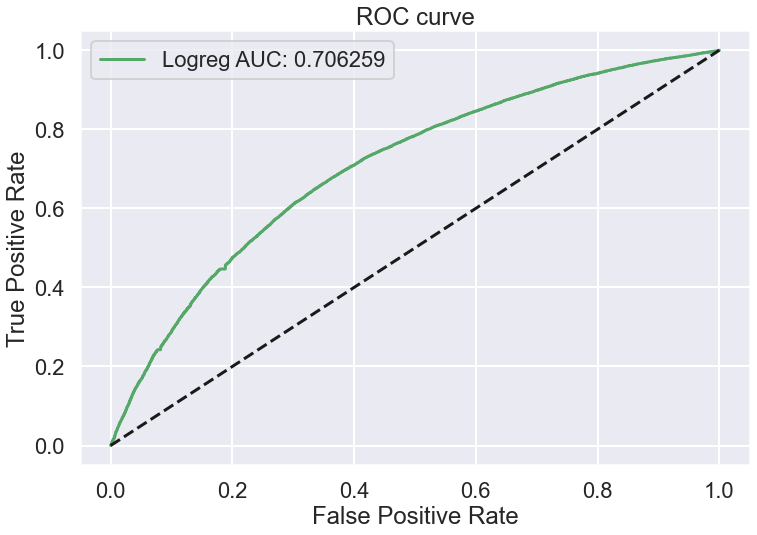

In [1003]:
y_pred_proba_logreg = logreg.predict_proba(X_test_scaled)[:, 1]
logreg_roc_auc = roc_auc_score(y_test, y_pred_proba_logreg)
plot_roc_curve(y_test, y_pred_proba_logreg, color='g', 
               label="Logreg AUC: {:5f}".format(logreg_roc_auc))

Значение `ROC-AUC`: $0.706259$.

Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).

С помощью `LogisticRegressionCV` подберем параметр `C` для `LogisticRegression`

In [1008]:
logit_c_values = np.logspace(-4, 2, 10)
skf = StratifiedKFold(n_splits=3)

def grid_score(y_true, y_pred, **kwargs):
    return roc_auc_score(y_true, y_pred)

scorer = make_scorer(grid_score)


logit_grid_searcher = LogisticRegressionCV(Cs=logit_c_values,
                                           random_state=RANDOM_SEED,
                                           cv=skf,
                                           n_jobs=-1,
                                           scoring=scorer)

In [1009]:
%%time

logit_grid_searcher.fit(X_train_scaled, y_train)

CPU times: user 1.15 s, sys: 2.14 s, total: 3.28 s
Wall time: 2min 3s


LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='auto',
                     n_jobs=-1, penalty='l2', random_state=7, refit=True,
                     scoring=make_scorer(grid_score), solver='lbfgs',
                     tol=0.0001, verbose=0)

In [1010]:
logit_mean_cv_scores = np.array(list(logit_grid_searcher.scores_.values()))\
                                .mean(axis = (0, 1))

In [1011]:
best_score1 = np.amax(logit_mean_cv_scores)
best_C1 = logit_grid_searcher.Cs_[np.argmax(logit_mean_cv_scores)]

print(f'Лучшее среднее значение ROC-AUC: {best_score1} для С = {best_C1}')

Лучшее среднее значение ROC-AUC: 0.6524824749626387 для С = 1.0


Нарисуем график зависимости ROC-AUC score на кросс-валидации от `C`.

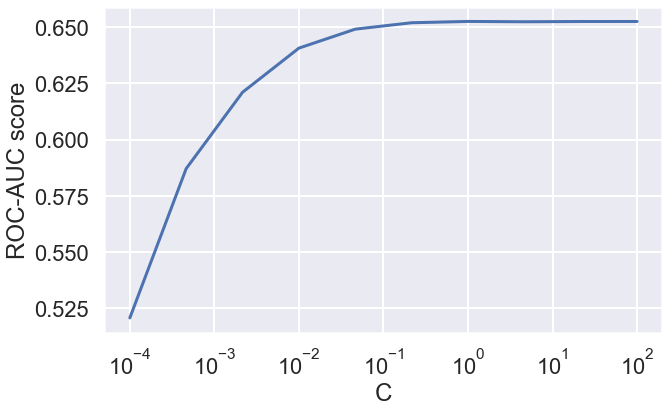

In [1012]:
plt.figure(figsize=(10, 6))
sns.set_context('poster')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('ROC-AUC score')
plt.plot(logit_c_values, logit_mean_cv_scores);

Теперь будем искать `C` в более узком диапазоне.

In [1014]:
logit_c_values2 = np.linspace(1, 100, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2,
                                            random_state=RANDOM_SEED,
                                            cv=skf,
                                            n_jobs=-1,
                                            scoring=scorer)

In [1015]:
%%time

logit_grid_searcher2.fit(X_train_scaled, y_train)

CPU times: user 761 ms, sys: 504 ms, total: 1.27 s
Wall time: 1min 39s


LogisticRegressionCV(Cs=array([  1.        ,   6.21052632,  11.42105263,  16.63157895,
        21.84210526,  27.05263158,  32.26315789,  37.47368421,
        42.68421053,  47.89473684,  53.10526316,  58.31578947,
        63.52631579,  68.73684211,  73.94736842,  79.15789474,
        84.36842105,  89.57894737,  94.78947368, 100.        ]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='auto',
                     n_jobs=-1, penalty='l2', random_state=7, refit=True,
                     scoring=make_scorer(grid_score), solver='lbfgs',
                     tol=0.0001, verbose=0)

In [1016]:
logit_mean_cv_scores2 = np.array(list(logit_grid_searcher2.scores_.values()))\
                                .mean(axis = (0, 1))

best_score2 = np.amax(logit_mean_cv_scores2)
best_C2 = logit_grid_searcher2.Cs_[np.argmax(logit_mean_cv_scores2)]

print(f'Лучшее среднее значение ROC-AUC: {best_score2} для С = {best_C2}')

Лучшее среднее значение ROC-AUC: 0.6527325947678758 для С = 6.2105263157894735


Нарисуем график зависимости ROC-AUC score на кросс-валидации от `C`.

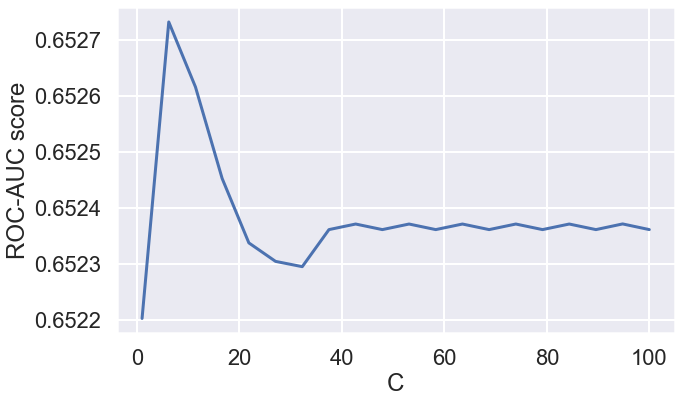

In [1017]:
plt.figure(figsize=(10, 6))
sns.set_context('poster')
plt.xlabel('C')
plt.ylabel('ROC-AUC score')
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Обучим логистическую регрессию на всей тренировочной выборке с лучшим значением `C`.

In [1018]:
%%time

logreg2 = LogisticRegression(C=best_C2, random_state=RANDOM_SEED)\
                            .fit(X_train_scaled, y_train)

CPU times: user 17.5 s, sys: 372 ms, total: 17.9 s
Wall time: 9.82 s


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [1019]:
y_pred_proba_logreg2 = logreg2.predict_proba(X_test_scaled)[:, 1]
logreg_roc_auc2 = roc_auc_score(y_test, y_pred_proba_logreg2)

Сравним логистические регрессии между собой.

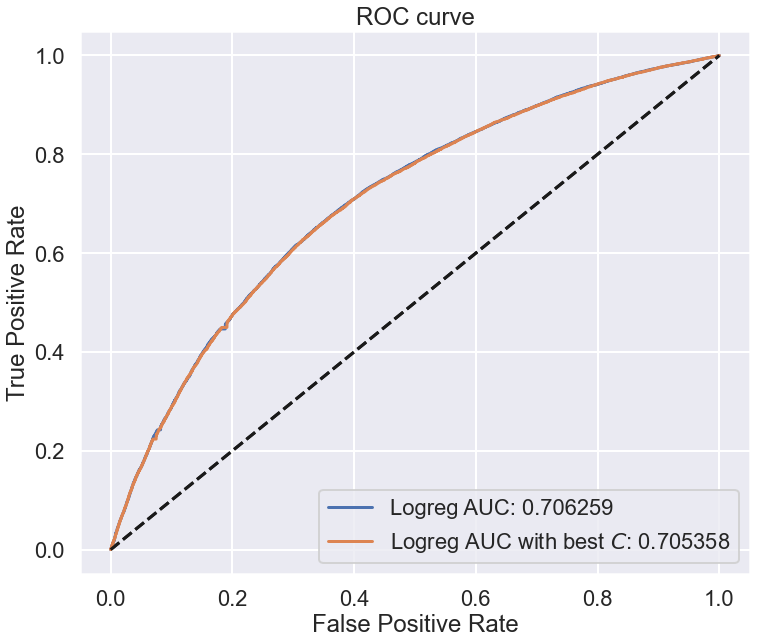

In [1020]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1)

plot_roc_curve(
    y_test,
    y_pred_proba_logreg,
    ax=ax,
    label="Logreg AUC: {:5f}".format(logreg_roc_auc),
)
plot_roc_curve(
    y_test,
    y_pred_proba_logreg2,
    ax=ax,
    label="Logreg AUC with best $C$: {:5f}".format(logreg_roc_auc2),
)
ax.legend(loc=4);

Качество модели осталось почти таким же.

## Pipeline (собираем все вместе)

Применим каждый шаг к текстам новостей с Telegram-канала РИА новости. Возьмем новости за сентябрь 2020 года.

In [1173]:
cur_data = ria_news[ria_news['Date'] < pd.to_datetime('2020.10').date()].copy()

Создадим класс, отвечающий за токенизацию и лемматизацию русских текстов.

In [1090]:
class LemmaTokenizerRus:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`', '&', "'", 
                     '-']
    def __init__(self):
        self.morph = pymorphy2.MorphAnalyzer()
        
    def __call__(self, doc):
        return [self.morph.parse(t)[0].normal_form
                for t in regexp_tokenize(doc, r'[а-яА-Я]{2,}') 
                if t not in self.ignore_tokens]

Реализуем функцию, которая принимает исходный `DataFrame` и возвращает метки кластеров и взвешенных тексты самых важных слов для каждого кластера.

In [1112]:
def clustering(df):
    stop_words_rus = set(stopwords.words('russian')) 
    # Инициализация объекта класса
    tokenizer_rus = LemmaTokenizerRus()
    # Формирирование множества стоп-слов
    stop_words_rus = set(stopwords.words('russian')) 
    token_stop_rus = tokenizer_rus(' '.join(stop_words_rus))
    
    # Создание TF-IDF модели
    vectorizer_rus = TfidfVectorizer(stop_words=token_stop_rus, 
                                     tokenizer=tokenizer_rus,
                                     ngram_range=(1, 2), # Испрользуем униграммы и биграммы слов
                                     max_df=0.7, # Игнорируем слова, частота встречания которых в тексте >= 70% 
                                     min_df=10 # Игнорируем слова, встречающиеся реже 10 раз
                                    )
    # Получение матрицы признаков
    doc_vectors_rus = vectorizer_rus.fit_transform(df['Text'])
    
    # Лист для хранения значений силуэта
    km_silhouette = []

    # Перебор числа кластеров
    for i in range(2, 11):
        km = KMeans(n_clusters=i, 
                    random_state=RANDOM_SEED).fit(doc_vectors_rus)
        preds = km.predict(doc_vectors_rus)
        silhouette = silhouette_score(doc_vectors_rus, preds)
        km_silhouette.append(silhouette)
    
    # Лучшее число кластеров
    best_num_of_clusters = np.argmax(km_silhouette) + 2
    
    # Обучаем модель кластеризации на лучшем числе кластеров
    k_means = KMeans(n_clusters=best_num_of_clusters,
                     random_state=RANDOM_SEED)

    # Предсказания модели
    preds_km = k_means.fit_predict(doc_vectors_rus)
    
    # Индексы 10 самых значимых слов кластеров
    main_words_idx = np.argsort(k_means.cluster_centers_)[:, :-10:-1]
    
    # Значения 10 самых важных слов кластеров
    main_words_values = np.sort(k_means.cluster_centers_)[:, :-10:-1]

    # 10 самых значимых слов для каждого из кластеров
    main_words = []
    for row in main_words_idx:
        main_words.append([vectorizer_rus.get_feature_names()[idx]
                           for idx in row])
    
    # Уровень значимости для каждого слова
    main_words_values = np.ceil(main_words_values * 1000).astype(int)

    # Массив взвешенных текстов на основе значимых слов и их весов
    weighted_texts = []
    for row_word, row_weight in zip(main_words, main_words_values):
        words = []
        for word, weight in zip(row_word, row_weight):
            words += [word] * weight
        weighted_texts.append(' '.join(words))
        
    return preds_km, weighted_texts

In [1113]:
ria_preds_km, ria_weighted_texts = clustering(cur_data)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['вс', 'ещ'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Создадим функцию, которая на вход принимает исходный `DataFrame`, модель для предсканий и модель для масштабирования данных и возвращает предсказания для каждого объекта выборки.

In [1130]:
def classification(df, model, scaler):
    
    # Исходные тексты
    texts = df['Text'].values
    
    # Векторное представление текстов
    X_vec = []
    
    # Размерность вектора
    n_dim = 300

    # Преобразование текстов в вектора
    for text in texts:
        X_vec.append(buildWordVector(text, n_dim))
        
    X_vec = np.array(X_vec)
    
    # Масштабирование векторов    
    X_scaled = scaler.transform(X_vec)
    
    # Предсказание модели
    predicions = model.predict_proba(X_scaled)
    
    return predicions
    
    

In [1131]:
ria_pred = classification(cur_data, logreg, scaler)

Последний этап - визуализация полученных результатов работы кластеризации и классификации. Для всех новостей, которые попали в один класстер, мы визуализируем графически вероятности отнесения их к классу "Агрессивный" и "Позитивный" с течением времени. Также ждя каждого кластера визуализируем облака самых важных слов. 

In [1269]:
def visualization(df, k_pred, c_pred, weighted_texts):
    
    # Добавляем столбцы
    df = df.copy()
    df['Сluster'] = k_pred
    df['Neg'] = c_pred[:, 0]
    df['Pos'] = c_pred[:, 1]
    
    # Группирируем DataFrame
    df_groups = df.groupby(by=['Date', 'Сluster'], as_index=False)\
                  .agg({'Neg': 'mean', 'Pos': 'mean'})
    
    # Изображаем графики
    for cluster, weighted_text  in zip(set(k_pred), weighted_texts):
        sns.set_context('talk')
        
        # Получаем облако слов
        wordcloud = WordCloud(max_font_size=40, background_color='white',
                              max_words=10000, collocations=False,
                              random_state=RANDOM_SEED
                              )
        wordcloud = wordcloud.generate(weighted_text)
        
        # Инициализируем график
        fig = plt.figure(figsize=(16, 6))
        grid = plt.GridSpec(1, 3, hspace=0.2, wspace=0.2)
        main_ax = fig.add_subplot(grid[0, :2])
        words_ax = fig.add_subplot(grid[0, 2])
        
        # Визуализируем облако
        words_ax.imshow(wordcloud, interpolation="bilinear")
        words_ax.set_axis_off()
        words_ax.set_title(f'Облако значимых слов\nКластера {cluster + 1}')
        
        # Срез DataFrame по кластеру
        df_cluster = df_groups[df_groups['Сluster'] == cluster]
        
        # Визуализируем график изменения настроений
        sns.lineplot(x='Date', y='Neg', data=df_cluster, ax=main_ax, color='r')
        sns.lineplot(x='Date', y='Pos', data=df_cluster, ax=main_ax, color='g')
        main_ax.legend(classes)
        main_ax.set_ylim(0, 1)
        datemin = np.datetime64(df_cluster['Date'].values[0]) - np.timedelta64(1, 'D')
        datemax = np.datetime64(df_cluster['Date'].values[-1]) + np.timedelta64(1, 'D')
        main_ax.set_xlim(datemin, datemax)
        main_ax.set_ylabel('Вероятность принадлежности к классу')
        main_ax.set_xlabel('Дата')
        fig.autofmt_xdate(rotation=60)
        main_ax.set_title('График изменения отношения канала к данному кластеру новостей')
        plt.show()

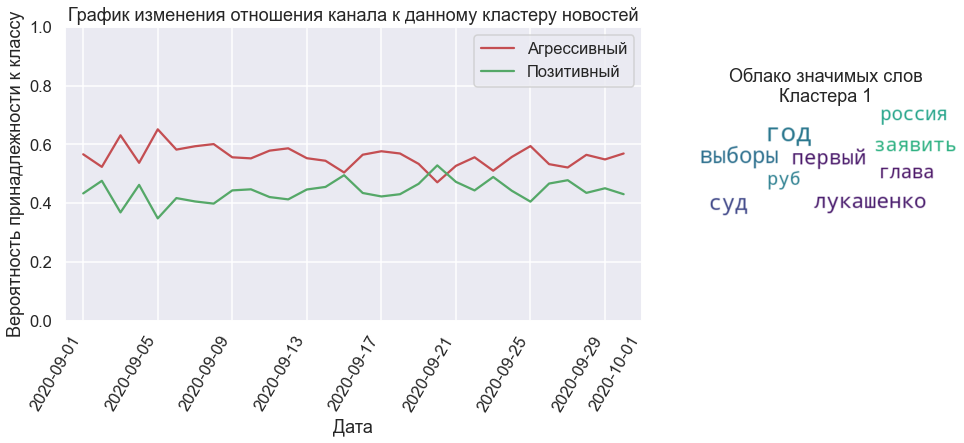

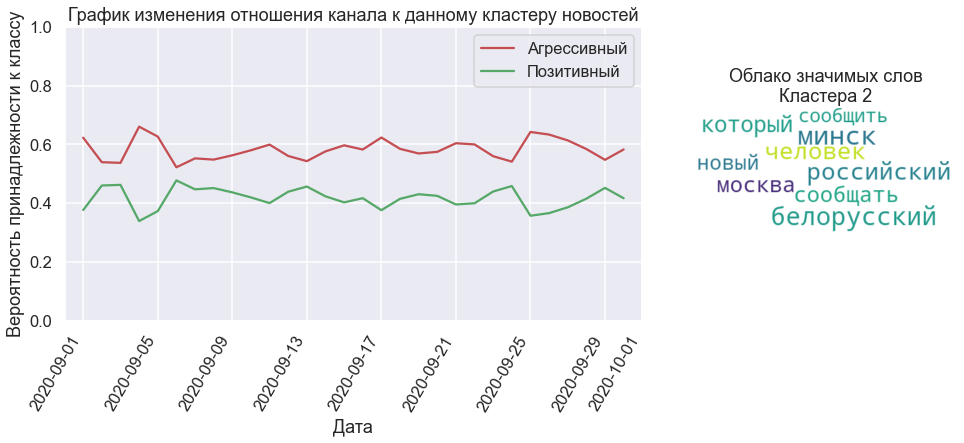

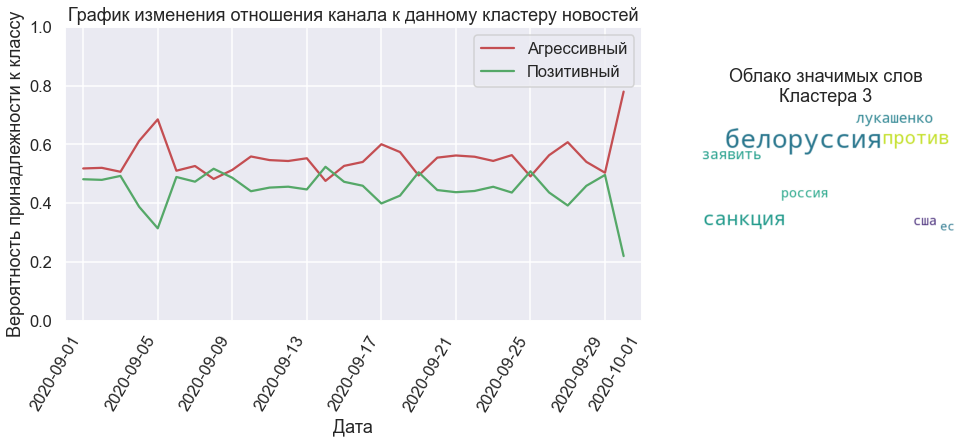

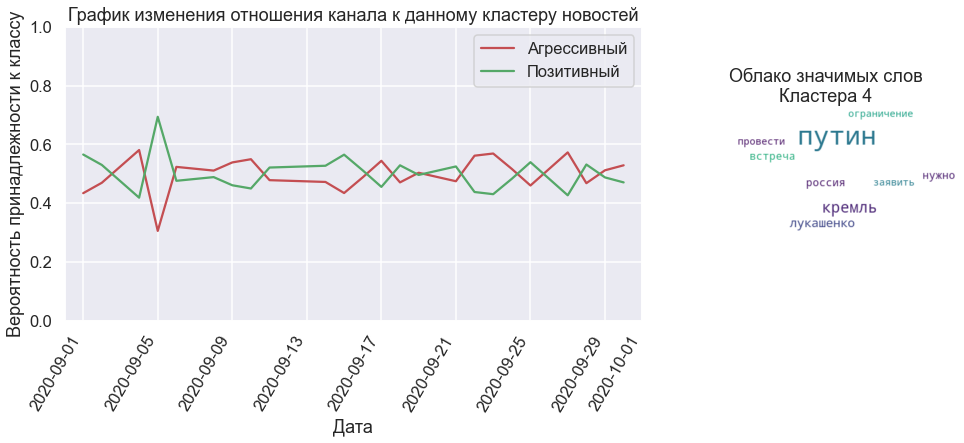

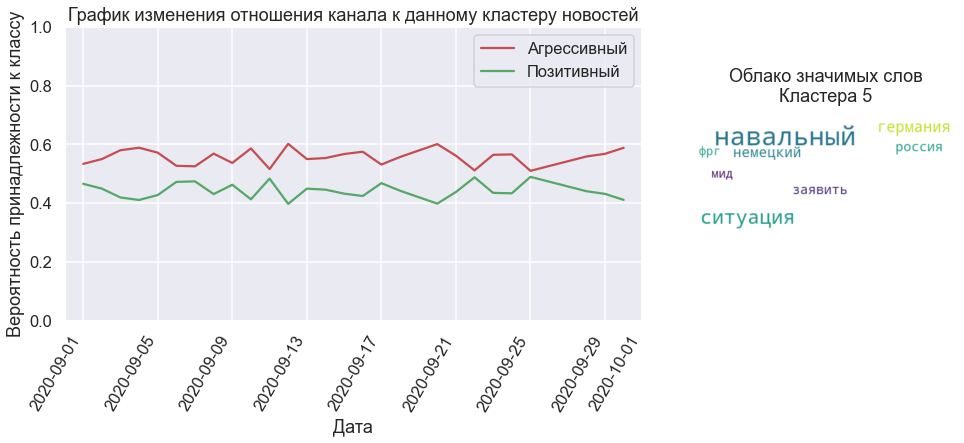

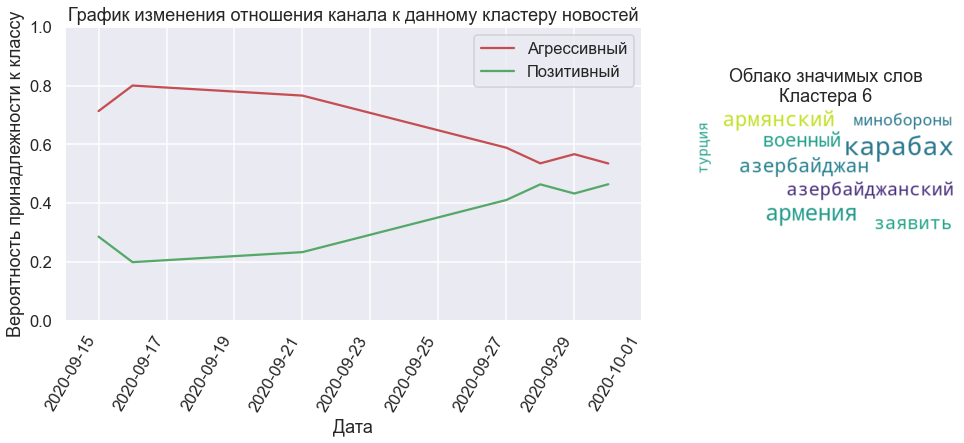

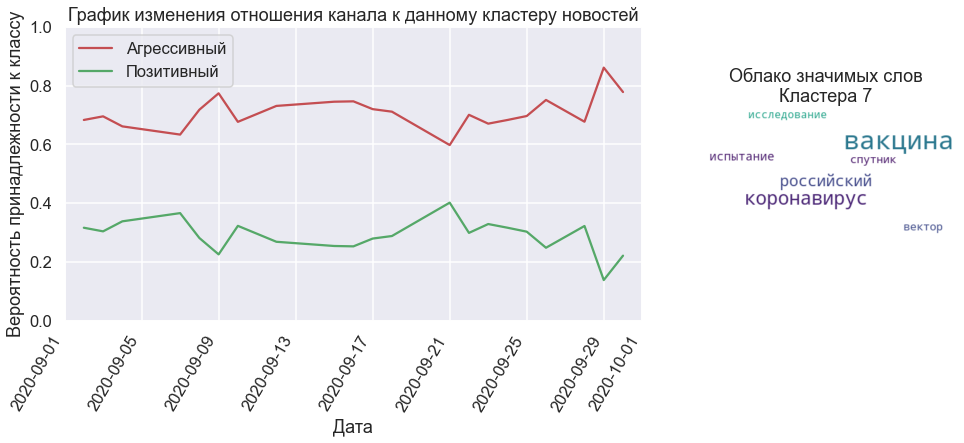

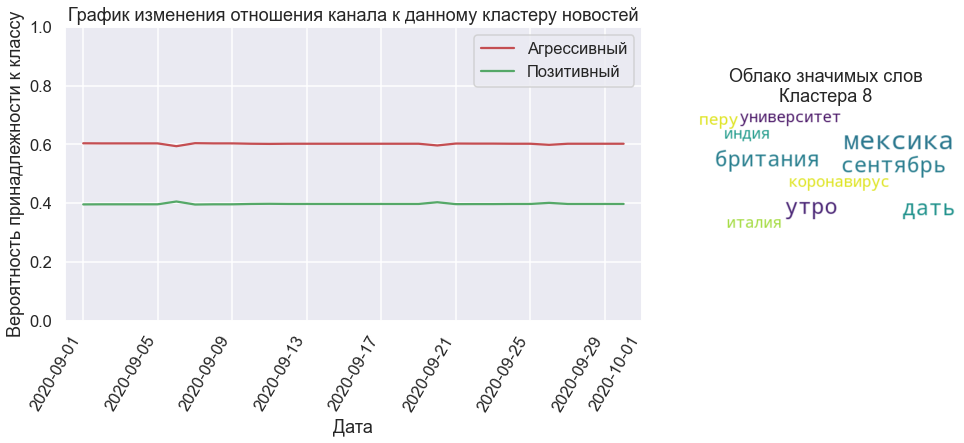

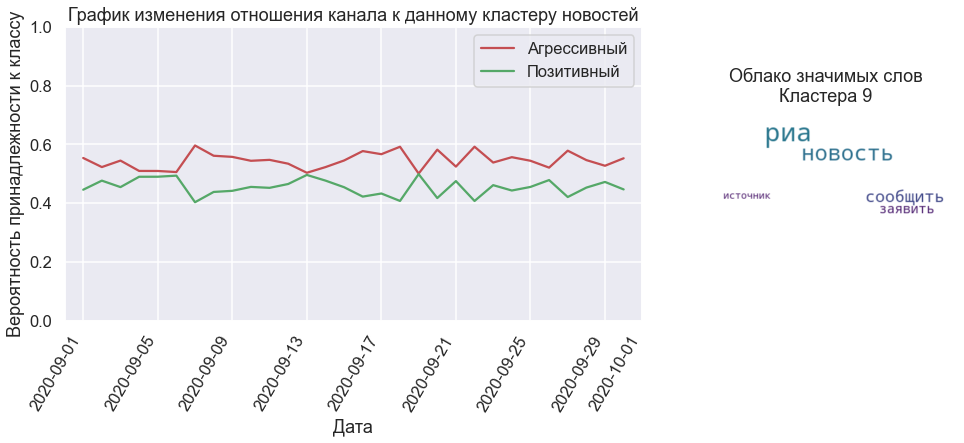

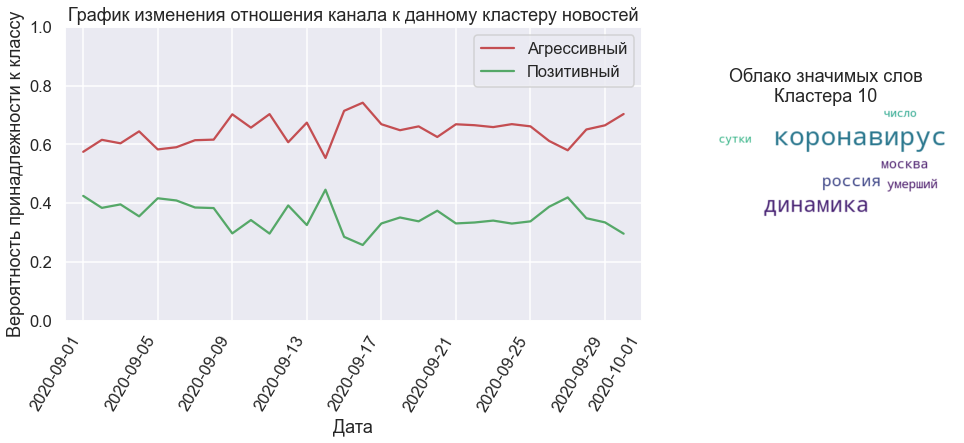

In [1270]:
visualization(cur_data, ria_preds_km, ria_pred, ria_weighted_texts)

Новости чаще нейтральные (кривые в диапазоне от $0.4$ до $0.6$). Слова кластеров являются репрезентативными. 

Рассмотрим, например, кластер $6$. Скорее всего, тематика данного кластера связана с конфликтом в Карабахе. Мы видим, что новости данной тематики сильно агрессивные.

Проанализируем Telegram-канал "Телеканал Дождь".

In [1271]:
rain_news = pd.read_csv('data/rain.csv', names=['Text', 'Date'], 
                        parse_dates=['Date'])
rain_news['Date'] = rain_news['Date'].dt.date

Возьмем новости за сентябрь-январь 2020 года.

In [1276]:
rain_news = rain_news[rain_news['Date'] < pd.to_datetime('2021.01').date()].copy()

In [1278]:
rain_preds_km, rain_weighted_texts = clustering(rain_news)
rain_pred = classification(rain_news, logreg, scaler)

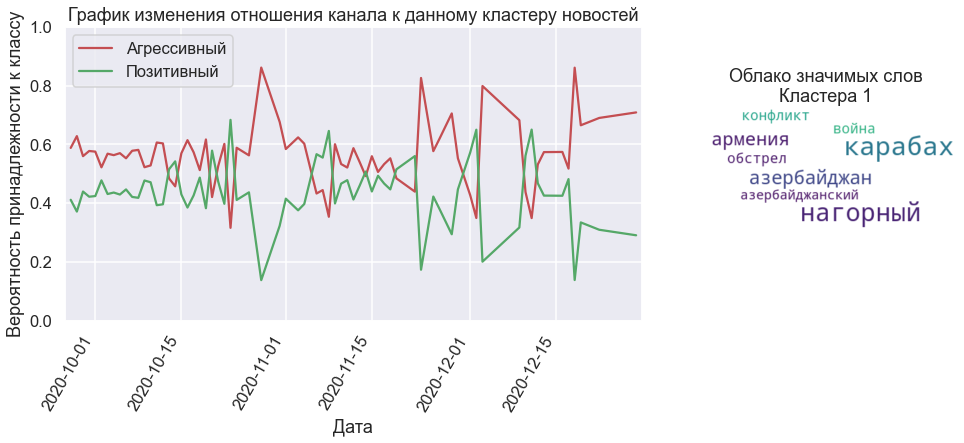

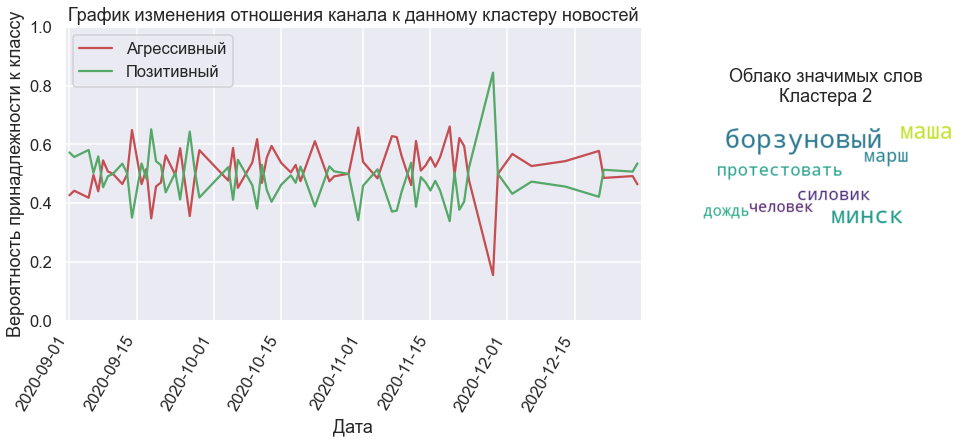

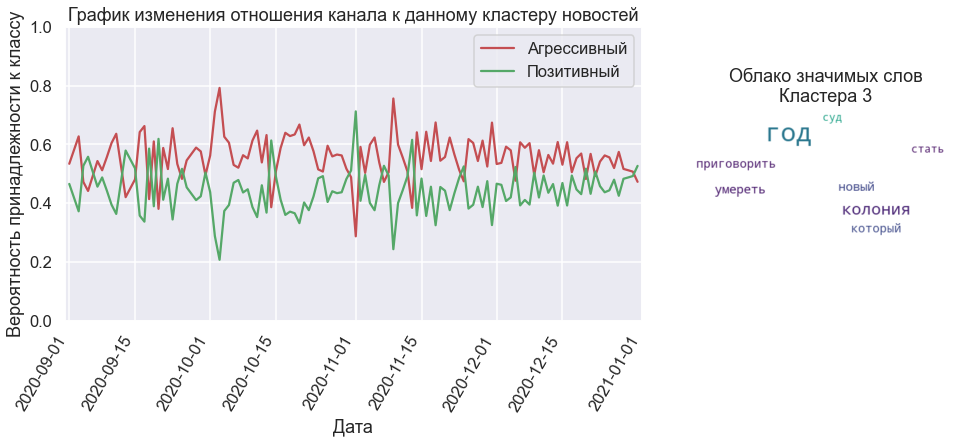

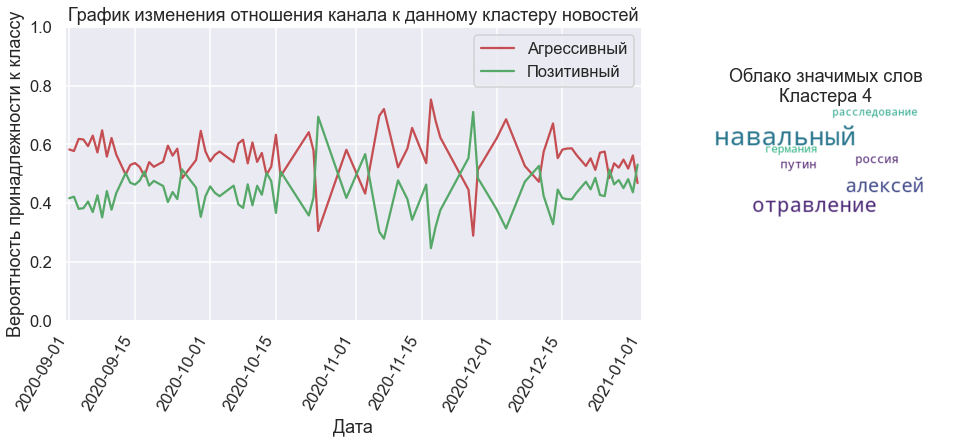

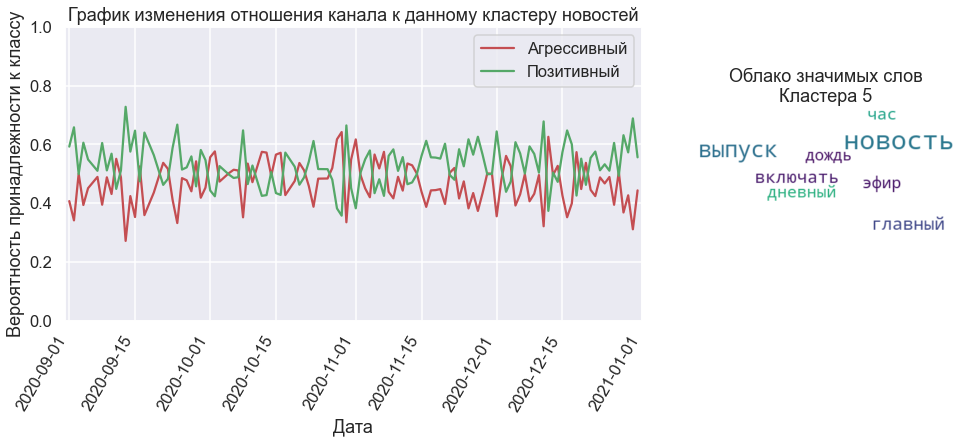

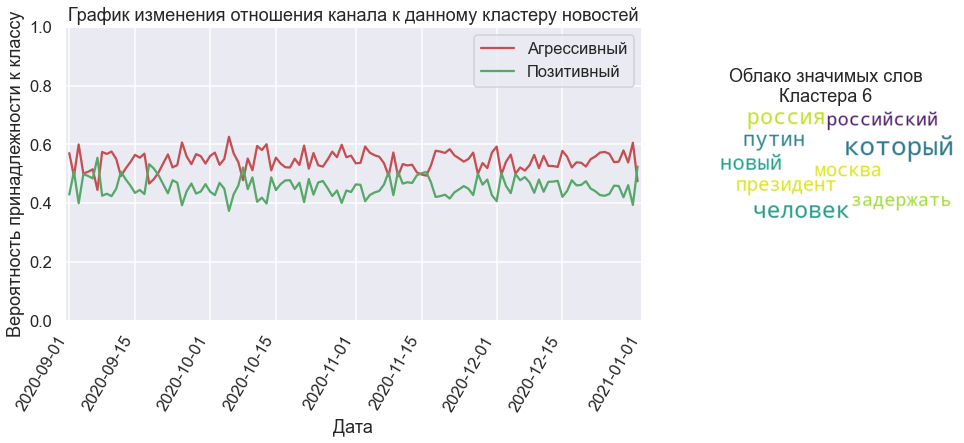

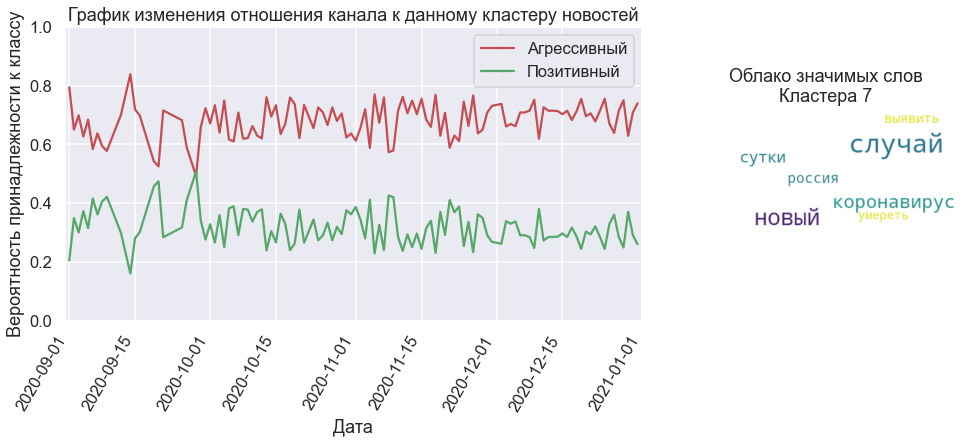

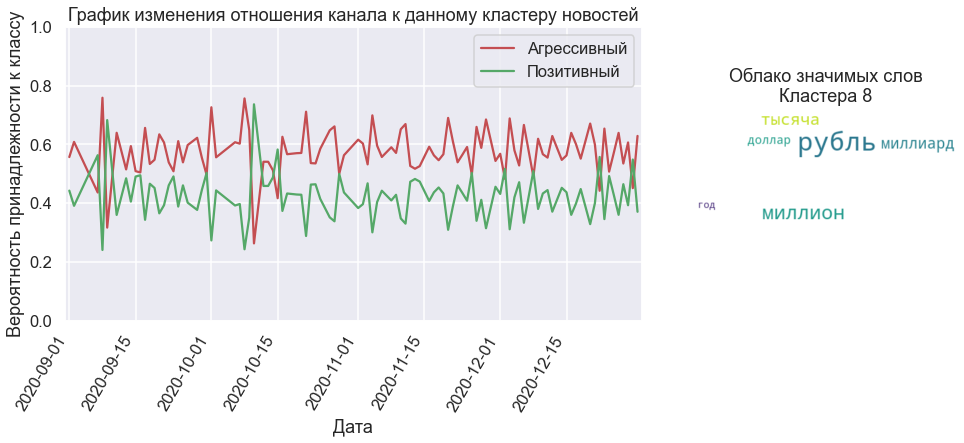

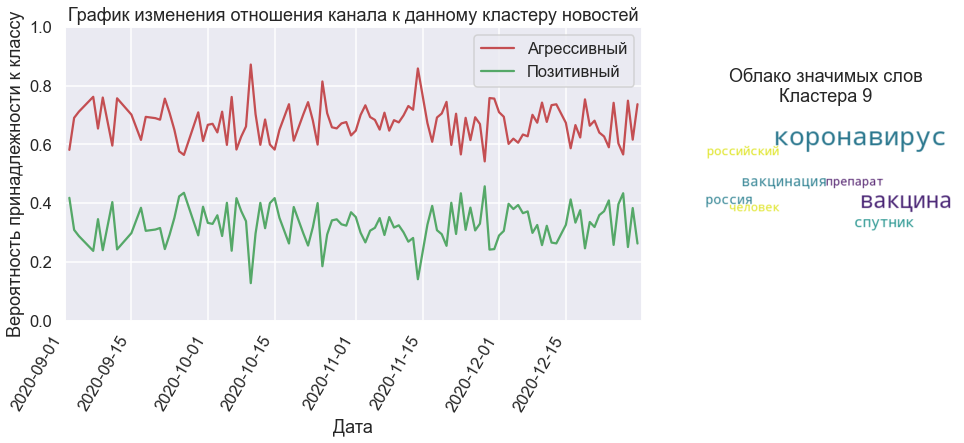

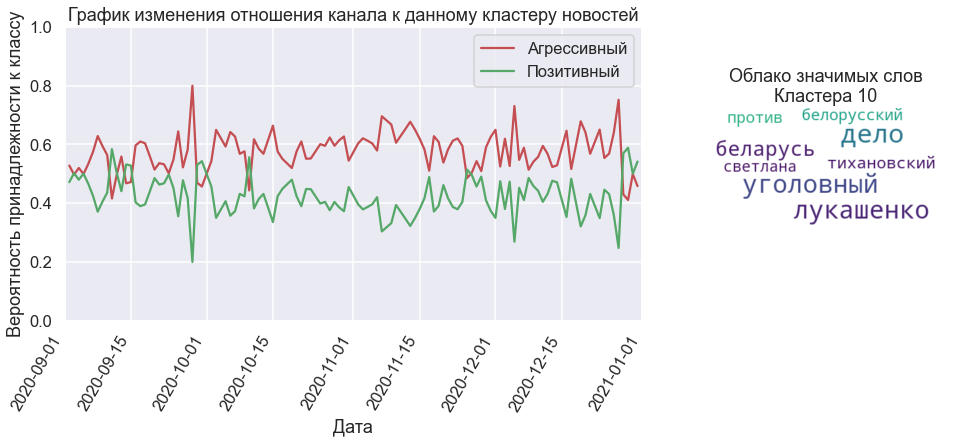

In [1279]:
visualization(rain_news, rain_preds_km, rain_pred, rain_weighted_texts)